The DBpedia ontology classification dataset was originally constructed from Wikipedia articles and organized into 14 non-overlapping topic classes. Each example consists of a title and a short content paragraph associated with a class label.

I used a balanced subset of the dataset containing 112,000 samples with 8,000 examples per class. Since the classes are evenly distributed, it is easier to preprocess and train models on compared to messier real-world datasets





Fancyzhx. (2014). DBpedia ontology classification dataset.
Retrieved from https://huggingface.co/datasets/fancyzhx/dbpedia_14

Dataset Link: https://huggingface.co/datasets/fancyzhx/dbpedia_14

X_Train shape: (448000, 256)
Label Shape: (448000, 14)
Vocab size: 30000


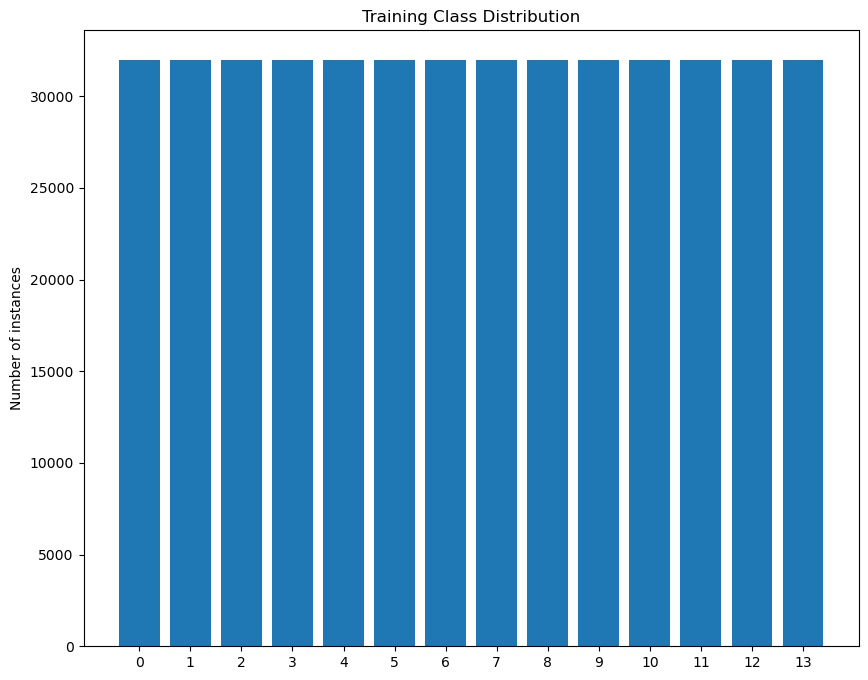

In [9]:
from datasets import load_dataset
from keras.src.layers import MultiHeadAttention
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical

import os
import re
import spacy
import numpy as np
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'

"""
https://www.datacamp.com/cheat-sheet/regular-expresso
"""
def clean_text(text):
    text = re.sub(r"<.*?>", " ", text)               # remove HTML tags
    text = re.sub(r"&\w+;", " ", text)               # remove HTML entities
    text = re.sub(r"[^a-z0-9\s]", " ", text)         # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()         # normalize spaces
    return text
    
    
dbpedia = load_dataset("dbpedia_14")

text = dbpedia["train"]["content"]
labels = dbpedia["train"]["label"]


NUM_CLASSES = 14
MAX_SEQ_LEN = 256 
MAX_VOCAB_SIZE = 30000   



X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=42, stratify=labels)

X_train = [clean_text(t) for t in X_train]
X_test = [clean_text(t) for t in X_test]

# Tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
X_train_cov_seq = tokenizer.texts_to_sequences(X_train)
X_test_cov_seq = tokenizer.texts_to_sequences(X_test)

# Pad Sequences
X_train = sequence.pad_sequences(X_train_cov_seq, maxlen=MAX_SEQ_LEN)
X_test = sequence.pad_sequences(X_test_cov_seq, maxlen=MAX_SEQ_LEN)

#One Hot 
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

print(f"X_Train shape: {X_train.shape}")
print(f"Label Shape: {y_train.shape}")
print(f"Vocab size: {MAX_VOCAB_SIZE}")

class_count = np.sum(y_train, axis=0)
plt.figure(figsize=(10, 8))
plt.bar(range(NUM_CLASSES), class_count)
plt.xticks(range(NUM_CLASSES))
plt.ylabel("Number of instances")
plt.title("Training Class Distribution")
plt.show()

## Dataset Preparation, Evaluation Metrics, and Split Method


### Methods of Tokenization/Sequence Length

For tokenization, I used Keras Tokenization because the DBPedia dataset is very large at 560,000+, so to keep the model size reasonable and memory limited I capped the vocabulary at 30,000 and also capped the sequence length to 256 since we don't need the entire documents tokens. The entries in the dataset varies in length more often than not, so the sequence length seemed like a good compromise and lead to consistent input shape into the model.

I chose macro-averaged F1 for model evaluation. This decision was motivated by a paper on DBpedia ontology classification (Zhang et al., 2023), which uses the same method of metrics. Thier justification was that the ontology mapping and type prediction are multi class problems where each class is equally important even for distributively balanced classes. These assumption lines up with my use case as the class distribution in my dataset are more or less balanced, but each label represents a semantic category. Mistakes in prediction of one class wouldn't have equal impact another class, so just averaging across makes sense in this case rather letting a heavy class take over accuracy metrics. This relates to the similar business case the researchers in the paper were studying. If I were to use the semantic classifier models evaluated in this lab in a knowledge graph system, id want equally performance across all classes, macro F1 would reinforce my goal of fairness in models.

For the test/training I chose a stratified 20/80 split. Stratification keeps the class distribution the same in both sets equal to avoid imbalances. I didn't want to use n-fold cross validation because this would greatly increase the training time and not very practical for me since im limited on compute power. Also, a single split might be more realistic as for this type of classifier you usually train on one large chunk of text then evaluate on held out document sets the model hasn't seen. This leaves a good amount of data the model can train on to learn enough stable patterns and get as close to generalization as possible.

Zhang, Z., Wang, Z., & Iwaihara, M. (2023). Mapping Wikipedia Categories and Lists to DBPedia Ontology Based on Structural and Semantic Features. DEIM Forum. https://proceedings-of-deim.github.io/DEIM2023/1b-3-4.pdf

## Modeling

In [27]:

# Baseline CNN Model

from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dropout, GlobalMaxPool1D, Dense
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

VOCAB_SIZE = MAX_VOCAB_SIZE
EMBEDDING_SIZE = 64
SEQ_LEN = MAX_SEQ_LEN

inputs = Input(shape=SEQ_LEN, dtype='int32')

# Using my original embeddings
embedding = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_SIZE,
    input_length=SEQ_LEN)(inputs)

x = Conv1D(64, 5, activation='relu', kernel_initializer='he_uniform')(embedding)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)

x = Conv1D(64, 5, activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)

x = Conv1D(64, 5, activation='relu', kernel_initializer='he_uniform')(x)
x = GlobalMaxPool1D()(x)

x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)

preds = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)
model = Model(inputs, preds)

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True
)

optimizer = Adam(epsilon=0.0001, learning_rate=lr_schedule)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256)]             0         
                                                                 
 embedding_9 (Embedding)     (None, 256, 64)           1920000   
                                                                 
 conv1d_27 (Conv1D)          (None, 252, 64)           20544     
                                                                 
 max_pooling1d_18 (MaxPooli  (None, 50, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_26 (Dropout)        (None, 50, 64)            0         
                                                                 
 conv1d_28 (Conv1D)          (None, 46, 64)            20544     
                                                           

In [28]:
histories = []
baseline_hist = model.fit(
    X_train, y_train, 
    epochs=5, 
    validation_data=(X_test, y_test),
    batch_size=128)
histories.append(baseline_hist)

Epoch 1/5


2025-12-10 14:24:53.870789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - ETA: 0s - loss: 0.4229 - acc: 0.8620

2025-12-10 14:25:54.862920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - 67s 19ms/step - loss: 0.4229 - acc: 0.8620 - val_loss: 0.1566 - val_acc: 0.9533
Epoch 2/5
3500/3500 [==============================] - 59s 17ms/step - loss: 0.1560 - acc: 0.9545 - val_loss: 0.1470 - val_acc: 0.9568
Epoch 3/5
3500/3500 [==============================] - 67s 19ms/step - loss: 0.1378 - acc: 0.9602 - val_loss: 0.1550 - val_acc: 0.9557
Epoch 4/5
3500/3500 [==============================] - 68s 19ms/step - loss: 0.1854 - acc: 0.9558 - val_loss: 0.3053 - val_acc: 0.9475
Epoch 5/5
3500/3500 [==============================] - 60s 17ms/step - loss: 1.4171 - acc: 0.9395 - val_loss: 3.2699 - val_acc: 0.9384


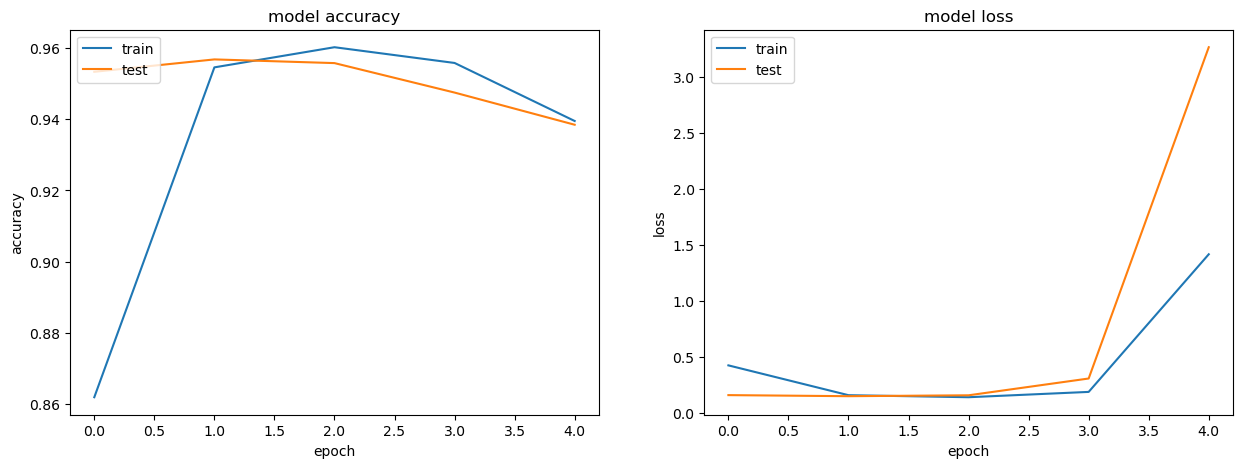

In [29]:
# Adapted from: https://github.com/eclarson/MachineLearningNotebooks/blob/master/13a.%20Sequence%20Basics%20%5Bexperimental%5D.ipynb

from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Baseline CNN Model Results

I first trained a baseline CNN to get a reference point before moving on to more complex models. The model uses an embedding layer followed by several 1D convolution layers with max pooling and dropout, and a final dense classifier.

From the accuracy and loss curves, the model learns quickly at the beginning. Validation accuracy reaches around 95–96% by the second epoch, which shows that the CNN is able to pick up useful local text patterns for topic classification. However, after about epoch 3 the training becomes unstable. Both training and validation loss increase sharply, and accuracy starts to drop.

This behavior suggests overfitting and unstable optimization rather than smooth convergence. Even with dropout, the CNN struggles to maintain performance across later epochs. This is likely because convolutional models mainly capture local features and do not model longer-range dependencies in the text very well.

Overall, while the baseline CNN performs reasonably well early in training, the loss curves show that it does not converge cleanly. 

In [40]:
from tensorflow.keras.layers import GlobalAveragePooling1D, Subtract, Concatenate, LayerNormalization


VOCAB_SIZE = MAX_VOCAB_SIZE
EMBEDDING_SIZE = 64
SEQ_LEN = MAX_SEQ_LEN

inputs = Input(shape=SEQ_LEN, dtype='int32')

# Using my original embeddings
embedding = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_SIZE,
    input_length=SEQ_LEN)(inputs)

x = Conv1D(128, 5, activation='relu', kernel_initializer='he_uniform')(embedding)
x = LayerNormalization()(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.1)(x)

x = Conv1D(128, 5, activation='relu', kernel_initializer='he_uniform')(x)
x = LayerNormalization()(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.1)(x)

x = Conv1D(128, 5, activation='relu', kernel_initializer='he_uniform')(x)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)


# Adding mean and average variance pooling
x = LayerNormalization()(x)
x_mean = GlobalAveragePooling1D()(x)
# Taking the average
x_centered = Subtract()([x, x_mean])
x_var = GlobalAveragePooling1D()(x_centered ** 2)

x = Concatenate()([x_mean, x_var])

x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)


preds = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)
cnn_model_b = Model(inputs, preds)

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True
)

optimizer = Adam(epsilon=1e-5, learning_rate=lr_schedule)

cnn_model_b.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

cnn_model_b.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, 256, 64)              1920000   ['input_15[0][0]']            
                                                                                                  
 conv1d_42 (Conv1D)          (None, 252, 128)             41088     ['embedding_14[0][0]']        
                                                                                                  
 layer_normalization_1 (Lay  (None, 252, 128)             256       ['conv1d_42[0][0]']           
 erNormalization)                                                                          

In [41]:
histories_b = []

history_b = cnn_model_b.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_test, y_test)
)

histories_b.append(history_b)

Epoch 1/5


2025-12-10 17:27:25.274349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3498/3500 [============================>.] - ETA: 0s - loss: 0.8963 - acc: 0.7059

2025-12-10 17:28:52.437555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - 95s 27ms/step - loss: 0.8959 - acc: 0.7061 - val_loss: 0.2314 - val_acc: 0.9325
Epoch 2/5
3500/3500 [==============================] - 100s 28ms/step - loss: 0.2142 - acc: 0.9362 - val_loss: 0.1766 - val_acc: 0.9487
Epoch 3/5
3500/3500 [==============================] - 118s 34ms/step - loss: 0.1515 - acc: 0.9547 - val_loss: 0.1620 - val_acc: 0.9535
Epoch 4/5
3500/3500 [==============================] - 117s 33ms/step - loss: 0.1207 - acc: 0.9638 - val_loss: 0.1641 - val_acc: 0.9550
Epoch 5/5
3500/3500 [==============================] - 116s 33ms/step - loss: 0.1009 - acc: 0.9696 - val_loss: 0.1611 - val_acc: 0.9557


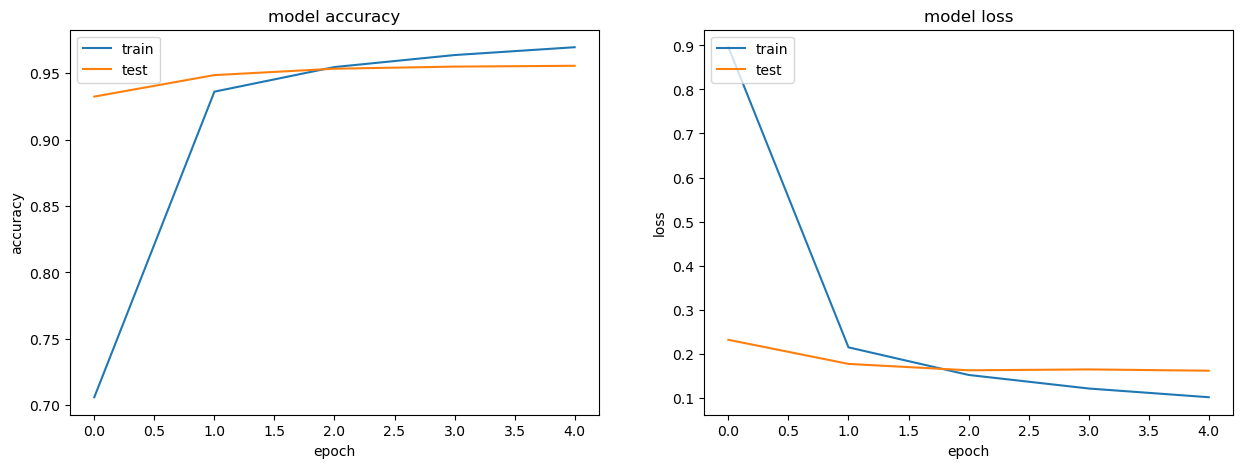

In [43]:


# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_b])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## CNN Model B Results

CNN Model B builds on the baseline CNN by adding more convolution filters, layer normalization, and a different pooling strategy that keeps more information from the feature maps.

Looking at the accuracy plot, this model improves very quickly after the first epoch and then steadily increases across training. The training and validation accuracy curves stay close to each other, which is a good sign that the model is not heavily overfitting. By the final epoch, validation accuracy is around 95–96%, which is higher and more stable than the baseline CNN.

The loss curves also look much better than the baseline model. Both training and validation loss decrease smoothly and do not spike at later epochs like before. This suggests that the added normalization layers and dropout helped control exploding loss and made optimization more reliable.

Overall, it is a clear improvement over the baseline CNN. It trains more smoothly, reaches higher accuracy, and shows better generalization.

## Transformer Models

In [54]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer
import tensorflow as tf

# Transformer Block and Position Embeddings
# Embeddings are based my own and not pre-trained
class TransformerBlock(Layer):
    def __init__(self, embed_dims, num_head, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_head, key_dim=embed_dims)
        self.ffn = Sequential([Dense(ff_dim, activation='relu'),
                               Dense(embed_dims)])
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
        
    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(Layer):
    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embedding = Embedding(vocab_size, embed_dim)
        self.position_embedding = Embedding(max_len, embed_dim)
        
    def call(self, x):
        max_len = tf.shape(x)[-1]
        position = tf.range(0, max_len, delta=1)
        position = self.position_embedding(position)
        x = self.token_embedding(x)
        return x + position

In [55]:
# Transformer Model A

embed_dims = 32
num_head = 1
ff_dim = 64
max_len = MAX_SEQ_LEN # 256 Seq Length

inputs = Input((max_len,), dtype='int32')

x = TokenAndPositionEmbedding(VOCAB_SIZE, embed_dims, max_len)(inputs)

# Block 1
x = TransformerBlock(embed_dims, num_head, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(64, 'relu')(x)
x = Dropout(0.1)(x)

outputs = Dense(NUM_CLASSES, activation='softmax')(x)

transformer_model_A = Model(inputs, outputs)

transformer_model_A.compile(loss='categorical_crossentropy', 
                            optimizer='rmsprop', 
                            metrics=['acc'])

transformer_model_A.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 256)]             0         
                                                                 
 token_and_position_embeddi  (None, 256, 32)           968192    
 ng_4 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_4 (Trans  (None, 256, 32)           8544      
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_1  (None, 32)                0         
 3 (GlobalAveragePooling1D)                                      
                                                                 
 dropout_61 (Dropout)        (None, 32)                0  

In [58]:
histories_trans_a = []

hist_trans_a = transformer_model_A.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_test, y_test)
)

histories_trans_a.append(hist_trans_a)

Epoch 1/5
3500/3500 [==============================] - 378s 108ms/step - loss: 0.0611 - acc: 0.9838 - val_loss: 0.0639 - val_acc: 0.9825
Epoch 2/5
3500/3500 [==============================] - 385s 110ms/step - loss: 0.0596 - acc: 0.9842 - val_loss: 0.0656 - val_acc: 0.9822
Epoch 3/5
3500/3500 [==============================] - 380s 109ms/step - loss: 0.0588 - acc: 0.9846 - val_loss: 0.0639 - val_acc: 0.9825
Epoch 4/5
3500/3500 [==============================] - 381s 109ms/step - loss: 0.0585 - acc: 0.9846 - val_loss: 0.0650 - val_acc: 0.9830
Epoch 5/5
3500/3500 [==============================] - 381s 109ms/step - loss: 0.0576 - acc: 0.9848 - val_loss: 0.0680 - val_acc: 0.9820


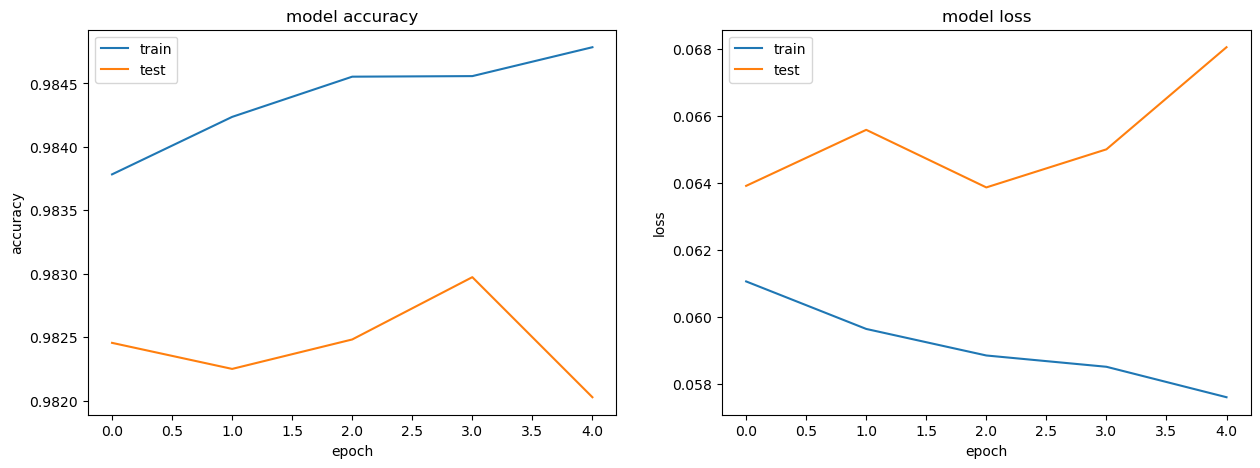

In [59]:
# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_trans_a])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [62]:
# Transformer Model B

embed_dims = 64
num_heads = 2
ff_dim = 64
max_len = MAX_SEQ_LEN # 256 Seq Length

inputs = Input((max_len,), dtype='int32')

x = TokenAndPositionEmbedding(VOCAB_SIZE, embed_dims, max_len)(inputs)

# Block 1
x = TransformerBlock(embed_dims, num_heads, ff_dim)(x)

# Block 2
x = TransformerBlock(embed_dims, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.25)(x)
x = Dense(128, 'relu')(x)
x = Dropout(0.25)(x)

outputs = Dense(NUM_CLASSES, activation='softmax')(x)

transformer_model_B = Model(inputs, outputs)

transformer_model_B.compile(loss='categorical_crossentropy', 
                            optimizer='rmsprop', 
                            metrics=['acc'])

transformer_model_B.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 256)]             0         
                                                                 
 token_and_position_embeddi  (None, 256, 64)           1936384   
 ng_6 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_7 (Trans  (None, 256, 64)           41792     
 formerBlock)                                                    
                                                                 
 transformer_block_8 (Trans  (None, 256, 64)           41792     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_1  (None, 64)                0  

In [63]:
histories_trans_b = []

hist_trans_b = transformer_model_B.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_test, y_test)
)

histories_trans_b.append(hist_trans_b)

Epoch 1/5


2025-12-11 16:38:16.443433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - ETA: 0s - loss: 0.1763 - acc: 0.9505

2025-12-11 17:04:05.633601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - 1700s 485ms/step - loss: 0.1763 - acc: 0.9505 - val_loss: 0.0806 - val_acc: 0.9778
Epoch 2/5
3500/3500 [==============================] - 1448s 414ms/step - loss: 0.0719 - acc: 0.9814 - val_loss: 0.0902 - val_acc: 0.9761
Epoch 3/5
3500/3500 [==============================] - 1441s 412ms/step - loss: 0.0627 - acc: 0.9840 - val_loss: 0.0609 - val_acc: 0.9840
Epoch 4/5
3500/3500 [==============================] - 1430s 408ms/step - loss: 0.0581 - acc: 0.9848 - val_loss: 0.0599 - val_acc: 0.9845
Epoch 5/5
3500/3500 [==============================] - 1440s 411ms/step - loss: 0.0540 - acc: 0.9859 - val_loss: 0.0557 - val_acc: 0.9847


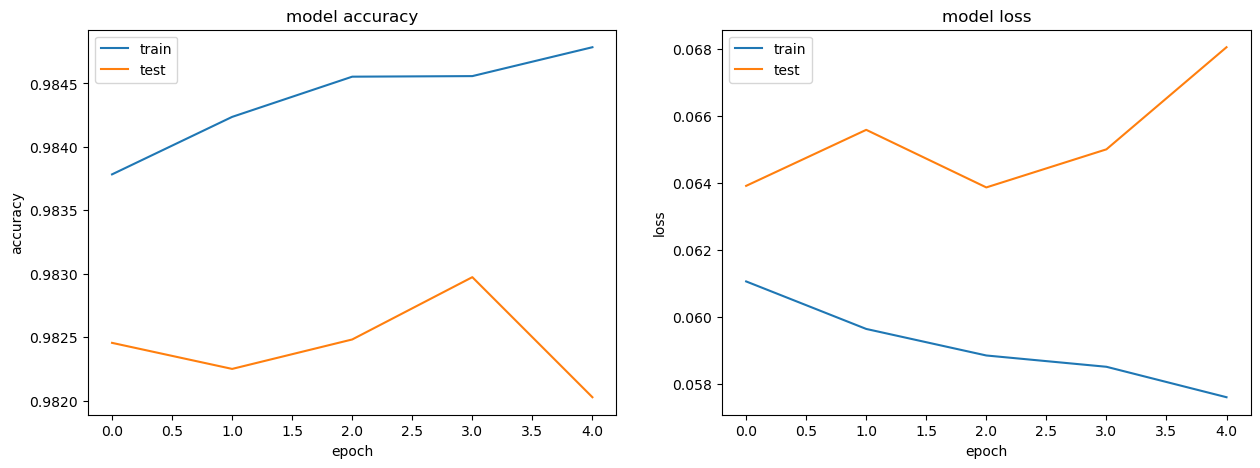

In [64]:
# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_trans_b])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Transformer Model B Results

Transformer B extends the previous transformer by adding a second self-attention block and increasing the embedding size. This gives the model more capacity to capture longer-range dependencies in the text compared to Transformer A.

From the accuracy plot, the model improves quickly after the first epoch and then stabilizes. Training and validation accuracy track each other very closely, ending around 98.5%–98.7%. The small gap between the two curves suggests good generalization and very little overfitting.

The loss curves show clear convergence. Training loss steadily decreases across epochs, while validation loss also drops and remains low. There are no sudden spikes or divergence between training and validation loss, which indicates stable optimization even with the deeper architecture.

Overall, Transformer B achieves the best performance so far among all models tested. The additional transformer layer improves results compared to Transformer A, but at the cost of significantly longer training time.

## Transformer B Parameters with Learning Rate Scheduler

In [65]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import RMSprop

embed_dims = 64
num_heads = 2
ff_dim = 64
max_len = MAX_SEQ_LEN # 256 Seq Length

inputs = Input((max_len,), dtype='int32')

x = TokenAndPositionEmbedding(VOCAB_SIZE, embed_dims, max_len)(inputs)

# Block 1
first_layer = TransformerBlock(embed_dims, num_heads, ff_dim)(x)

# Block 2
second_layer = TransformerBlock(embed_dims, num_heads, ff_dim)(first_layer)

x = GlobalAveragePooling1D()(second_layer)
x = Dropout(0.25)(x)
x = Dense(128, 'relu')(x)
x = Dropout(0.25)(x)

outputs = Dense(NUM_CLASSES, activation='softmax')(x)

transformer_model_C = Model(inputs, outputs)

lr_scheduler = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

optimizer = RMSprop(learning_rate=lr_scheduler)

transformer_model_C.compile(loss='categorical_crossentropy', 
                            optimizer=optimizer, 
                            metrics=['acc'])

transformer_model_C.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 256)]             0         
                                                                 
 token_and_position_embeddi  (None, 256, 64)           1936384   
 ng_7 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_9 (Trans  (None, 256, 64)           41792     
 formerBlock)                                                    
                                                                 
 transformer_block_10 (Tran  (None, 256, 64)           41792     
 sformerBlock)                                                   
                                                                 
 global_average_pooling1d_1  (None, 64)                0  

In [66]:
histories_trans_c = []

hist_trans_c = transformer_model_C.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_test, y_test)
)

histories_trans_c.append(hist_trans_c)

Epoch 1/5


2025-12-11 20:45:23.098381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - ETA: 0s - loss: 0.1739 - acc: 0.9506

2025-12-11 21:08:09.239597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - 1521s 433ms/step - loss: 0.1739 - acc: 0.9506 - val_loss: 0.0666 - val_acc: 0.9832
Epoch 2/5
3500/3500 [==============================] - 1428s 408ms/step - loss: 0.0701 - acc: 0.9820 - val_loss: 0.0682 - val_acc: 0.9814
Epoch 3/5
3500/3500 [==============================] - 1484s 424ms/step - loss: 0.0614 - acc: 0.9842 - val_loss: 0.0532 - val_acc: 0.9854
Epoch 4/5
3500/3500 [==============================] - 1429s 408ms/step - loss: 0.0562 - acc: 0.9856 - val_loss: 0.0585 - val_acc: 0.9836
Epoch 5/5
3500/3500 [==============================] - 1476s 422ms/step - loss: 0.0534 - acc: 0.9863 - val_loss: 0.0622 - val_acc: 0.9846


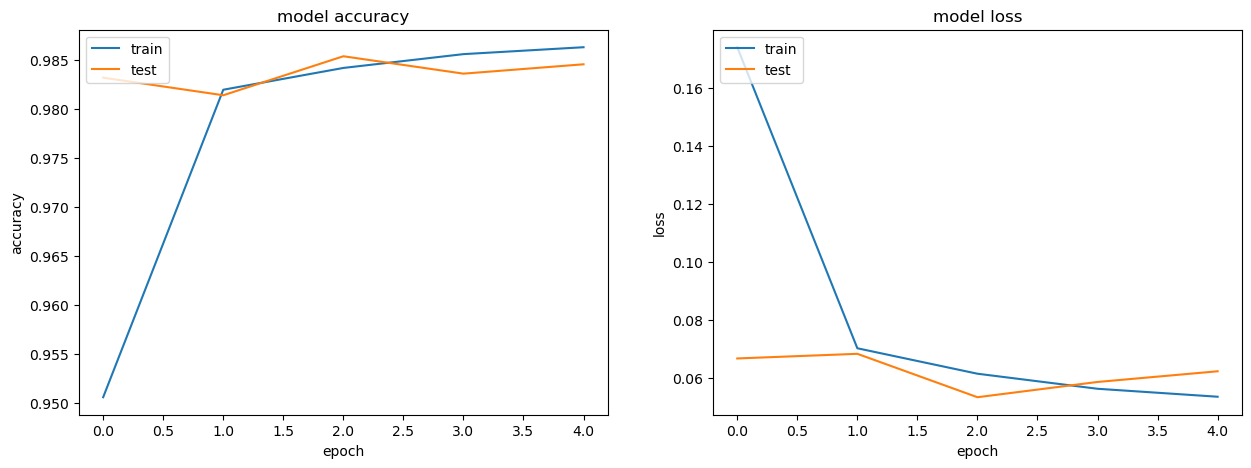

In [67]:
# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_trans_c])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Transformer Model B with Learning Rate Scheduler Results

This version of Transformer B uses the same two-block transformer architecture but adds a learning rate scheduler to gradually reduce the step size during training.

Looking at the accuracy curves, the model improves very quickly after the first epoch and then levels off. Training and validation accuracy stay very close throughout, finishing around 98.4–98.6%. The validation accuracy peaks slightly higher than in the non-scheduled version at some points, which suggests the scheduler helps fine-tune the model toward the later epochs.

The loss curves show clean convergence. Training loss steadily decreases, while validation loss drops early and remains low with only small fluctuations. There is no sign of divergence or instability, even with the deeper architecture and long training time.

Overall, adding a learning rate scheduler slightly improves training stability and gives marginal gains in validation performance.

## Macro F1 Scores and Classification

In [71]:
# Macro-F1 Reference: https://www.v7labs.com/blog/f1-score-guide 
from sklearn.metrics import f1_score, classification_report


# Labels
y_true = np.argmax(y_test, axis=1)
y_pred_cnn_baseline = np.argmax(model.predict(X_test), axis=1)
y_pred_cnn_model_b  = np.argmax(cnn_model_b.predict(X_test), axis=1)
y_pred_trans_model_a  = np.argmax(transformer_model_A.predict(X_test), axis=1) 
y_pred_trans_model_b = np.argmax(transformer_model_B.predict(X_test), axis=1)
y_pred_trans_model_c = np.argmax(transformer_model_C.predict(X_test), axis=1)

# F1-Scores
f1_baseline_cnn = f1_score(y_true,y_pred_cnn_baseline, average='macro')
f1_model_b_cnn = f1_score(y_true,y_pred_cnn_model_b , average='macro')
f1_model_a_trans = f1_score(y_true,y_pred_trans_model_a, average='macro')
f1_model_b_trans = f1_score(y_true,y_pred_trans_model_b, average='macro')
f1_model_c_trans = f1_score(y_true,y_pred_trans_model_c, average='macro')

print('F1-Macro Scores')
print(f'Baseline CNN: {f1_baseline_cnn: 0.4f}')
print(f'CNN Model B: {f1_model_b_cnn: 0.4f}')
print(f'Transformer A: {f1_model_a_trans:0.4f}')
print(f'Transformer B: {f1_model_b_trans: 0.4f}')
print(f'Transformer C: {f1_model_c_trans: 0.4f}')



3500/3500 [==============================] - 170s 49ms/step


2025-12-12 14:04:26.703620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - 171s 49ms/step
F1-Macro Scores
Baseline CNN:  0.0095
CNN Model B:  0.9558
Transformer A: 0.9820
Transformer B:  0.9847
Transformer C:  0.9846


In [72]:
print("Classification Report for Transformer B:")
print(classification_report(y_true, y_pred_trans_model_b, digits=4))

Classification Report for Transformer B:
              precision    recall  f1-score   support

           0     0.9753    0.9520    0.9635      8000
           1     0.9783    0.9879    0.9831      8000
           2     0.9755    0.9655    0.9705      8000
           3     0.9974    0.9912    0.9943      8000
           4     0.9618    0.9909    0.9761      8000
           5     0.9921    0.9908    0.9914      8000
           6     0.9631    0.9780    0.9705      8000
           7     0.9934    0.9941    0.9938      8000
           8     0.9965    0.9971    0.9968      8000
           9     0.9965    0.9869    0.9916      8000
          10     0.9883    0.9945    0.9914      8000
          11     0.9926    0.9895    0.9910      8000
          12     0.9855    0.9931    0.9893      8000
          13     0.9903    0.9740    0.9821      8000

    accuracy                         0.9847    112000
   macro avg     0.9848    0.9847    0.9847    112000
weighted avg     0.9848    0.9847    0.

The baseline CNN clearly did not work well for this task and failed to generalize across classes. CNN Model B performed much better, but both transformer models performed noticeably better than the CNNs overall. Transformer B had the highest macro-F1 score, even if only slightly higher than Transformer C.

Looking at the classification report for Transformer B, performance is strong across all 14 classes. Precision and recall stay high for every category, and there are no obvious weak classes. Since each class has the same number of samples, the macro and weighted F1 scores end up being almost identical, which shows the model is not biased toward any specific class.

Based on both the macro-F1 scores and the class-level results, Transformer B was selected as the best overall model for this task.

## Rotary Positional Embedding

In [98]:
# Reference for implementation: https://medium.com/@parulsharmmaa/understanding-rotary-positional-embedding-and-implementation-9f4ad8b03e32
"""
ChatGPT was used to help translate the RoPE equations into tensorflow compatible code,
since the reference implementation was written in PyTorch. RoPE is applied only to the 
query and key vectors and not the value as described in the medium article.

Because my version of tensorflow doesnt expose the internal query and key 
projections of the MultiHeadAttention layer, the attention computation had to be 
implemented manually to correctly apply RoPE. 
"""

class RotaryPositionalEmbedding(Layer):
    def __init__(self, dims, max_seq_len=256, base=10000):
        super().__init__()
        self.dims = dims
        self.max_seq_len = max_seq_len
        self.base = base
        
        
    def build(self, input_shape):
        half_dim = self.dims // 2
        theta = 1.0 / (self.base ** (tf.range(0, half_dim, dtype=tf.float32) / half_dim))
        positions = tf.range(self.max_seq_len, dtype=tf.float32)
        freqs = tf.einsum('i,j->ij', positions, theta)
        
        self.cos = tf.cos(freqs)
        self.sin = tf.sin(freqs)
        
    def call(self, x):
        seq_len = tf.shape(x)[1]
    
        x = tf.reshape(x, (-1, seq_len, self.dims // 2, 2))
        cos = self.cos[:seq_len][None, :, :]
        sin = self.sin[:seq_len][None, :, :]
        
        x_real = x[..., 0]
        x_imag = x[..., 1]
        
        out = tf.stack([
            x_real * cos - x_imag * sin,
            x_imag * cos + x_real * sin
        ], axis=-1)
        
        return tf.reshape(out, (-1, seq_len, self.dims))

In [99]:
# Reference for implementation: https://medium.com/@parulsharmmaa/understanding-rotary-positional-embedding-and-implementation-9f4ad8b03e32

class TransformerBlockRoPE(Layer):
    def __init__(self, embed_dims, num_heads, ff_dim, max_len, rate=0.1):
        super().__init__()
        self.embed_dims = embed_dims
        self.num_heads = num_heads
        self.head_dim = embed_dims // num_heads
        
        self.q_dense = Dense(embed_dims)
        self.k_dense = Dense(embed_dims)
        self.v_dense = Dense(embed_dims)
        
        self.rope = RotaryPositionalEmbedding(self.head_dim, max_len)
        
        self.ffn = Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dims)
        ])
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
          
    def split_heads(self, x):
        b, s = tf.shape(x)[0], tf.shape(x)[1]
        x = tf.reshape(x, (b, s, self.num_heads, self.head_dim))
        return tf.transpose(x, [0, 2, 1, 3])
        
    def call(self, x, training=False):
        q = self.split_heads(self.q_dense(x))
        k = self.split_heads(self.k_dense(x))
        v = self.split_heads(self.v_dense(x))
             
        # Apply RoPE to q and k heads
        b = tf.shape(q)[0]
        h = tf.shape(q)[1]
        s = tf.shape(q)[2]
        
        q = tf.reshape(q, [-1, s, self.embed_dims])
        k = tf.reshape(k, [-1, s, self.embed_dims])
        
        q = self.rope(q)
        k = self.rope(k)
        
        q = tf.reshape(q, [b, h, s, self.head_dim])
        k = tf.reshape(k, [b, h, s, self.head_dim])
        
        # Dot product attention
        scores = tf.matmul(q, k, transpose_b=True)
        scores = scores / tf.math.sqrt(tf.cast(self.head_dim, tf.float32))
        weights = tf.nn.softmax(scores, axis=-1)
        attn = tf.matmul(weights, v)
        
        # Merge Heads
        attn = tf.transpose(attn, [0, 2, 1, 3])
        attn = tf.reshape(attn, (-1, tf.shape(attn)[1], self.embed_dims))
        
        x = self.layernorm1(x + self.dropout1(attn, training=training))
        ffn = self.ffn(x)
        return self.layernorm2(x + self.dropout2(ffn, training=training))

In [100]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import RMSprop

embed_dims = 64
num_heads = 2
ff_dim = 64
max_len = MAX_SEQ_LEN # 256 Seq Length

inputs = Input((max_len,), dtype='int32')

x = Embedding(VOCAB_SIZE, embed_dims)(inputs)

# Block 1 RoPE
first_layer = TransformerBlockRoPE(embed_dims, num_heads, ff_dim, max_len)(x)

# Block 2 RoPE
second_layer = TransformerBlockRoPE(embed_dims, num_heads, ff_dim, max_len)(first_layer)

x = GlobalAveragePooling1D()(second_layer)
x = Dropout(0.25)(x)
x = Dense(128, 'relu')(x)
x = Dropout(0.25)(x)

outputs = Dense(NUM_CLASSES, activation='softmax')(x)

transformer_model_C_RoPE = Model(inputs, outputs)

lr_scheduler = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

optimizer = RMSprop(learning_rate=lr_scheduler)

transformer_model_C_RoPE.compile(loss='categorical_crossentropy', 
                            optimizer=optimizer, 
                            metrics=['acc'])

transformer_model_C_RoPE.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 256)]             0         
                                                                 
 embedding_41 (Embedding)    (None, 256, 64)           1920000   
                                                                 
 transformer_block_ro_pe_12  (None, 256, 64)           21056     
  (TransformerBlockRoPE)                                         
                                                                 
 transformer_block_ro_pe_13  (None, 256, 64)           21056     
  (TransformerBlockRoPE)                                         
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
 9 (GlobalAveragePooling1D)                                      
                                                          

In [107]:
histories_trans_c_RoPE = []

hist_trans_c_RoPE = transformer_model_C_RoPE.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_test, y_test)
)

histories_trans_c_RoPE.append(hist_trans_c_RoPE)

Epoch 1/5


2025-12-13 20:40:51.400534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - ETA: 0s - loss: 0.4943 - acc: 0.8460

2025-12-13 21:05:38.207130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - 1654s 471ms/step - loss: 0.4943 - acc: 0.8460 - val_loss: 0.1245 - val_acc: 0.9665
Epoch 2/5
3500/3500 [==============================] - 1428s 408ms/step - loss: 0.1085 - acc: 0.9719 - val_loss: 0.0867 - val_acc: 0.9768
Epoch 3/5
3500/3500 [==============================] - 1461s 417ms/step - loss: 0.0853 - acc: 0.9780 - val_loss: 0.0754 - val_acc: 0.9796
Epoch 4/5
3500/3500 [==============================] - 1649s 471ms/step - loss: 0.0745 - acc: 0.9806 - val_loss: 0.0708 - val_acc: 0.9815
Epoch 5/5
3500/3500 [==============================] - 1635s 467ms/step - loss: 0.0688 - acc: 0.9823 - val_loss: 0.0649 - val_acc: 0.9827


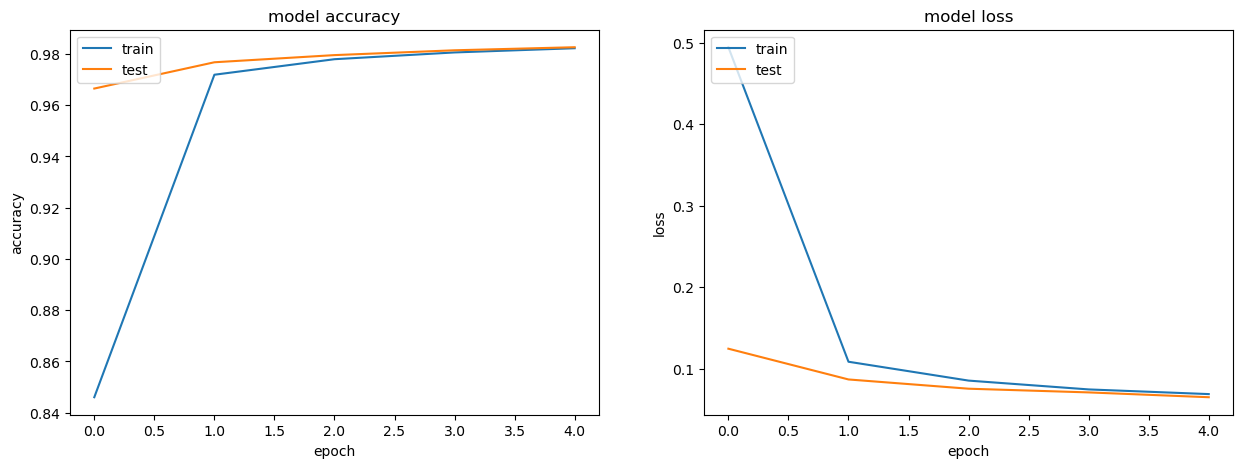

In [109]:
# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_trans_c_RoPE])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Sinusoidal Positional Embedding

In [103]:
# Reference for implementation: https://pub.aimind.so/creating-sinusoidal-positional-embedding-from-scratch-in-pytorch-98c49e153d6

class SinusoidalPositionalEmbedding(Layer):
    def __init__(self, max_len, embed_dim, base:10000):
        super().__init__()
        if embed_dim % 2 != 0:
            raise ValueError('Embedding dimension must be even')
        self.max_len = max_len
        self.embed_dim = embed_dim
        self.base = base
        
        
    def build(self, input_shape):
        position = tf.range(self.max_len,dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.pow(self.base, 2 * tf.range(self.embed_dim // 2, dtype=tf.float32) / self.embed_dim)
        
        pe= tf.zeros((self.max_len, self.embed_dim))
        
        pe_sin = tf.sin(position / div_term)
        pe_cos = tf.cos(position / div_term)
        
        pe = tf.concat([pe_sin, pe_cos], axis=-1)
        self.positional_embedding = pe[tf.newaxis, ...]
        
    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.positional_embedding[:, :seq_len, :]

In [105]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import RMSprop

embed_dims = 64
num_heads = 2
ff_dim = 64
max_len = MAX_SEQ_LEN # 256 Seq Length

inputs = Input((max_len,), dtype='int32')

x = Embedding(VOCAB_SIZE, embed_dims)(inputs)

x = SinusoidalPositionalEmbedding(max_len, embed_dims, 10000)(x)

# Block 1 Sinusoidal Embeddings
first_layer = TransformerBlock(embed_dims, num_heads, ff_dim,)(x)

# Block 2 Sinusoidal Embeddings
second_layer = TransformerBlock(embed_dims, num_heads, ff_dim)(first_layer)

x = GlobalAveragePooling1D()(second_layer)
x = Dropout(0.25)(x)
x = Dense(128, 'relu')(x)
x = Dropout(0.25)(x)

outputs = Dense(NUM_CLASSES, activation='softmax')(x)

transformer_model_C_SinEmbed = Model(inputs, outputs)

lr_scheduler = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

optimizer = RMSprop(learning_rate=lr_scheduler)

transformer_model_C_SinEmbed.compile(loss='categorical_crossentropy', 
                            optimizer=optimizer, 
                            metrics=['acc'])

transformer_model_C_SinEmbed.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 256)]             0         
                                                                 
 embedding_43 (Embedding)    (None, 256, 64)           1920000   
                                                                 
 sinusoidal_positional_embe  (None, 256, 64)           0         
 dding_1 (SinusoidalPositio                                      
 nalEmbedding)                                                   
                                                                 
 transformer_block_13 (Tran  (None, 256, 64)           41792     
 sformerBlock)                                                   
                                                                 
 transformer_block_14 (Tran  (None, 256, 64)           41792     
 sformerBlock)                                            

In [106]:
histories_trans_c_SinEmbed = []

hist_trans_c_sinembed = transformer_model_C_SinEmbed.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_test, y_test)
)

histories_trans_c_SinEmbed.append(hist_trans_c_sinembed)

Epoch 1/5


2025-12-13 13:32:09.069252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - ETA: 0s - loss: 0.5029 - acc: 0.8437

2025-12-13 13:56:15.045026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - 1590s 452ms/step - loss: 0.5029 - acc: 0.8437 - val_loss: 0.1094 - val_acc: 0.9716
Epoch 2/5
3500/3500 [==============================] - 1490s 426ms/step - loss: 0.1081 - acc: 0.9720 - val_loss: 0.0914 - val_acc: 0.9774
Epoch 3/5
3500/3500 [==============================] - 1551s 443ms/step - loss: 0.0852 - acc: 0.9783 - val_loss: 0.0759 - val_acc: 0.9800
Epoch 4/5
3500/3500 [==============================] - 1574s 450ms/step - loss: 0.0740 - acc: 0.9812 - val_loss: 0.0694 - val_acc: 0.9818
Epoch 5/5
3500/3500 [==============================] - 1593s 455ms/step - loss: 0.0685 - acc: 0.9826 - val_loss: 0.0680 - val_acc: 0.9826


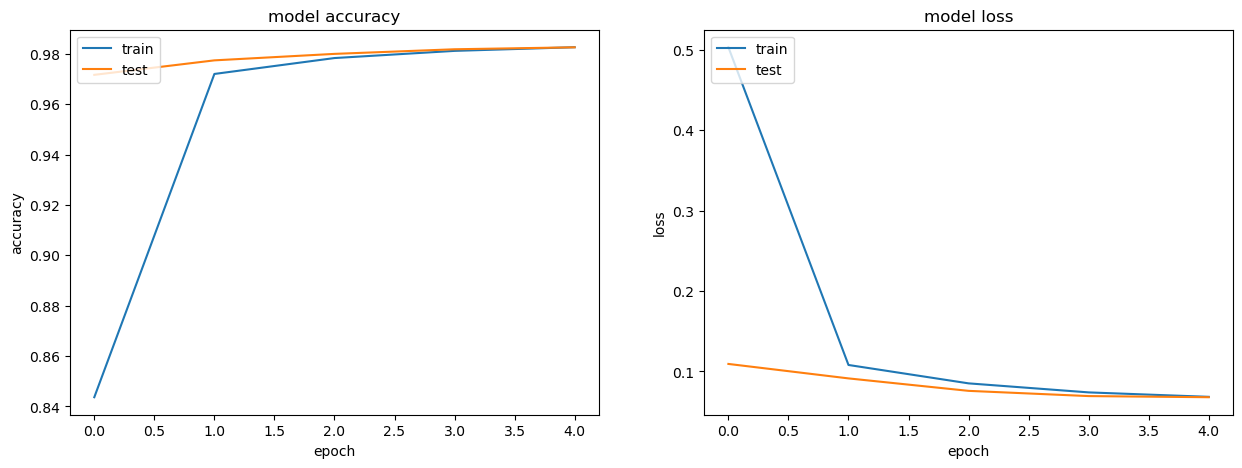

In [108]:
# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_trans_c_SinEmbed])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [110]:
# Labels
y_true = np.argmax(y_test, axis=1)

y_pred_trans_RoPE = np.argmax(transformer_model_C_RoPE.predict(X_test), axis=1)
y_pred_trans_SinEmbed  = np.argmax(transformer_model_C_SinEmbed.predict(X_test), axis=1)

# F1-Scores
f1_RoPE = f1_score(y_true,y_pred_trans_RoPE, average='macro')
f1_SinEmbed = f1_score(y_true,y_pred_trans_SinEmbed, average='macro')

print('F1-Macro Scores')
print(f'Rotary Positional Embedding: {f1_RoPE: 0.4f}')
print(f'Sinusoidal Embedding: {f1_SinEmbed: 0.4f}')


2025-12-14 11:52:35.791078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - 168s 47ms/step


2025-12-14 11:55:24.107309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - 175s 50ms/step
F1-Macro Scores
Rotary Positional Embedding:  0.9827
Sinusoidal Embedding:  0.9826


In [111]:
print("Classification Report for Transformer B with RoPE:")
print(classification_report(y_true, y_pred_trans_RoPE, digits=4))

Classification Report for Transformer B with RoPE:
              precision    recall  f1-score   support

           0     0.9520    0.9645    0.9582      8000
           1     0.9830    0.9809    0.9819      8000
           2     0.9717    0.9714    0.9716      8000
           3     0.9949    0.9921    0.9935      8000
           4     0.9840    0.9756    0.9798      8000
           5     0.9910    0.9820    0.9865      8000
           6     0.9673    0.9685    0.9679      8000
           7     0.9838    0.9920    0.9879      8000
           8     0.9946    0.9935    0.9941      8000
           9     0.9892    0.9891    0.9892      8000
          10     0.9894    0.9892    0.9893      8000
          11     0.9850    0.9924    0.9887      8000
          12     0.9915    0.9871    0.9893      8000
          13     0.9803    0.9788    0.9795      8000

    accuracy                         0.9827    112000
   macro avg     0.9827    0.9827    0.9827    112000
weighted avg     0.9827    0.

Both approaches perform almost identically on this dataset. RoPE is slightly higher, but the difference is very small and likely not statistically significant given the size and balance of the dataset.

Looking at the classification report for the RoPE model, performance is strong and consistent across all 14 classes. Precision and recall stay high for every category, and there are no obvious weak classes. This suggests the model is not over-fitting to any single topic and is learning fairly uniform semantic representations across categories.

Overall, this experiment shows that while RoPE is a more modern positional encoding method, for this task and dataset it does not provide a large performance advantage over traditional sinusoidal embeddings.

## References

Fancyzhx. (2014). DBpedia ontology classification dataset. Hugging Face.
https://huggingface.co/datasets/fancyzhx/dbpedia_14

Parul Sharma. (2024, August 27). A deep dive into rotary positional embeddings (RoPE): Theory and implementation. Medium.
https://medium.com/@parulsharmmaa/understanding-rotary-positional-embedding-and-implementation-9f4ad8b03e32

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, Ł., & Polosukhin, I. (2017). Attention is all you need. Advances in Neural Information Processing Systems (NeurIPS).
https://arxiv.org/abs/1706.03762

Zhang, Z., Wang, Z., & Iwaihara, M. (2023). Mapping Wikipedia categories and lists to DBpedia ontology based on structural and semantic features. DEIM Forum.
https://proceedings-of-deim.github.io/DEIM2023/1b-3-4.pdf